# Integer programming: the assignment problem

In [93]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from itertools import product
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

The functions below creates a networkx graph from an matrix with an assignment problem data 
and plots the graph. 

In [94]:
def graph_from_scores(scores):
    """
    Given an array with scores of the assignment problem 
    returns the corresponding weighted networkx graph. 
    Column nodes are labeled C1, C2, etc., row nodes P1, P2, etc.   

    scores:
        A 2-dimensional array with the assignment problem data.

    Returns: 
        A networkx weighted graph object.
    """

    df = pd.DataFrame(scores,
                      index=[f"P{i}" for i in range(1, scores.shape[0] + 1)],
                      columns=[f"C{i}" for i in range(1, scores.shape[1] + 1)])
    B = nx.Graph()  # Add nodes with the node attribute "bipartite"
    B.add_nodes_from([f"C{i}" for i in range(1, scores.shape[1] + 1)], bipartite=0)
    B.add_nodes_from([f"P{i}" for i in range(1, scores.shape[0] + 1)], bipartite=1)
    for p, c in product(df.index, df.columns):
        if not np.isnan(w := df.at[p, c]):
            B.add_edge(p, c, weight=w)
    return df, B


def plot_assignment_graph(B):
    """
    Plot the graph for an assignment problem. 

    B:
        A networkx object representing a weighted bipartite graph.
    
    Returns: 
        None. 
    """

    plt.figure(figsize=(10, 5))
    node_color = ['lightcoral' if n.startswith("C") else 'lightsteelblue' for n in B.nodes]
    nx.draw_networkx(
        B,
        pos = nx.drawing.layout.bipartite_layout(B, nodes = [n for n in B.nodes if n.startswith("C")]), 
        width = 3,
        node_color=node_color,
        node_size=1000
    )
    plt.show()


Create and plot the bipartite graph:

,C1,C2,C3,C4,C5,C6,C7
P1,70.0,90.0,,75.0,55.0,,60.0
P2,40.0,95.0,85.0,,,80.0,
P3,50.0,,75.0,,70.0,,65.0
P4,,,60.0,80.0,,35.0,
P5,,75.0,,70.0,,35.0,20.0


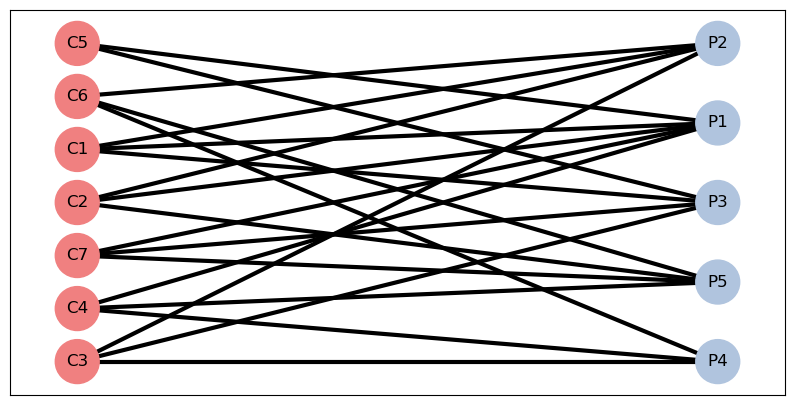

In [95]:
scores = np.array(
    [[70, 90, np.nan, 75, 55, np.nan, 60],
     [40, 95, 85, np.nan, np.nan, 80, np.nan],
     [50, np.nan, 75, np.nan, 70, np.nan, 65],
     [np.nan, np.nan, 60, 80, np.nan, 35, np.nan],
     [np.nan, 75, np.nan, 70, np.nan, 35, 20]])

df, B = graph_from_scores(scores)
df = df.fillna("")
display(df)
plot_assignment_graph(B)


### Solving the linear program for the assignment problem

The next function solves an assignment problem, using linear programming:

In [96]:
def lp_assignment(B):
    """
    Sets up and solves the assignment problem for
    a given weighted bipartite graph.
    
    B:
        A networkx object representing a weighted bipartite graph.
    
    Returns: 
       The data with the linear program solution returned by 
       scipy.optimize.linprog. 
    
    """
    weighted_incidence = nx.incidence_matrix(B, weight="weight").todense()
    edge_weights = weighted_incidence.max(axis=0)
    incidence = (weighted_incidence > 0).astype(int)
    num_slacks = len([n for n in B.nodes if n.startswith("C")])

    c = -edge_weights

    A_ub = incidence[:num_slacks]
    b_ub = np.ones(num_slacks)
    A_eq = incidence[num_slacks:]
    b_eq = np.ones(len(B.nodes) - num_slacks)

    sp = scipy.optimize.linprog(c=c,
                                A_ub=A_ub,
                                b_ub=b_ub,
                                A_eq=A_eq,
                                b_eq=b_eq)
    return sp

In [97]:
sol = lp_assignment(B)
sol

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -380.0
              x: [ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            nit: 9
          lower:  residual: [ 1.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
                 marginals: [ 0.000e+00  4.000e+01 ...  5.000e+00
                              3.500e+01]
          upper:  residual: [       inf        inf ...        inf
                                    inf]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          eqlin:  residual: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
                              0.000e+00]
                 marginals: [-7.000e+01 -8.000e+01 -7.000e+01 -6.500e+01
                             -5.500e+01]
        ineqlin:  residual: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
                              1.000e+00

Note that the solution consists of integers only:

In [98]:
sol.x

array([ 1.,  0.,  0., -0.,  0.,  1., -0.,  1.,  0.,  0.,  1., -0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.])

To get a readable solution of the assignment problem, it is now enough to print information about the edges of the graph for which the linear program solution is equal to 1:

In [85]:
edges = list(B.edges(data=True))
assignment = [edges[i] for i in np.nonzero(sol.x)[0]]
assignment

[('C1', 'P1', {'weight': 70.0}),
 ('C2', 'P5', {'weight': 75.0}),
 ('C3', 'P3', {'weight': 75.0}),
 ('C4', 'P4', {'weight': 80.0}),
 ('C6', 'P2', {'weight': 80.0})]

The sum of weights of the optimal assignment:

In [86]:
sum([w["weight"] for c, p, w in assignment])

380.0

# Assignment with random graphs

Create a random score matrix and solve the assignment problem for this matrix:

In [103]:
rng = np.random.default_rng()
cnum = 15
pnum = 7
edge_prob = 0.7
random_scores = rng.integers(0, 100, (pnum, cnum)).astype(float)
mask = rng.random((pnum, cnum)) > edge_prob
random_scores[mask] = np.nan
df, B = graph_from_scores(random_scores)
df = df.fillna("")
display(df)
#plot_assignment_graph(B)
sol = lp_assignment(B)
print(f"Linear program solution:\n{sol.x}")
edges = list(B.edges(data=True))
assignment = [edges[i] for i in np.nonzero(sol.x)[0]]
print("\nOptimal assignment:")
assignment

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15
P1,,57.0,58.0,4.0,,,89.0,81.0,57.0,18.0,,31.0,13.0,67.0,
P2,59.0,89.0,2.0,,81.0,,,94.0,,94.0,,97.0,,55.0,81.0
P3,,2.0,2.0,1.0,2.0,,38.0,44.0,54.0,59.0,35.0,23.0,,68.0,90.0
P4,,,,,5.0,54.0,83.0,65.0,31.0,,46.0,51.0,,4.0,96.0
P5,20.0,93.0,45.0,47.0,,5.0,53.0,28.0,30.0,99.0,6.0,45.0,22.0,53.0,
P6,,92.0,99.0,,49.0,54.0,99.0,34.0,32.0,,,36.0,61.0,4.0,
P7,20.0,,,41.0,,,31.0,28.0,44.0,10.0,36.0,57.0,6.0,,56.0


Linear program solution:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0. -0.  0.  0.  0. -0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  1.  0.  0.  0.  0.  0.  0. -0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0. -0.  1.
  0.]

Optimal assignment:


[('C3', 'P6', {'weight': 99.0}),
 ('C7', 'P1', {'weight': 89.0}),
 ('C8', 'P2', {'weight': 94.0}),
 ('C10', 'P5', {'weight': 99.0}),
 ('C12', 'P7', {'weight': 57.0}),
 ('C14', 'P3', {'weight': 68.0}),
 ('C15', 'P4', {'weight': 96.0})]